# 毕业项目：为 Arvato Financial Services 金融服务公司实现一个顾客分类报告

该项目要求你分析德国的一家邮购公司的顾客的人口统计数据，将它和一般的人口统计数据进行比较。你将使用非监督学习技术来实现顾客分类，识别出哪些人群是这家公司的基础核心用户。之后，你将把所学的知识应用到第三个数据集上，该数据集是该公司的一场邮购活动的营销对象的人口统计数据。用你搭建的模型预测哪些人更可能成为该公司的顾客。你要使用的数据由我们的合作伙伴 Bertelsmann Arvato Analytics 公司提供。这是真实场景下的数据科学任务。

如果你完成了这个纳米学位的第一学期，做过其中的非监督学习项目，那么你应该对这个项目的第一部分很熟悉了。两个数据集版本不同。这个项目中用到的数据集会包括更多的特征，而且没有预先清洗过。你也可以自由选取分析数据的方法，而不用按照既定的步骤。如果你选择完成的是这个项目，请仔细记录你的步骤和决策，因为你主要交付的成果就是一篇博客文章报告你的发现。

In [11]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import warnings
warnings.filterwarnings("ignore")
import time
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
# magic word for producing visualizations in notebook
%matplotlib inline

## 第 0 部分：了解数据

项目数据中包括四个数据文件

- `Udacity_AZDIAS_052018.csv`: 德国的一般人口统计数据；891211 人（行）x 366 个特征（列）
- `Udacity_CUSTOMERS_052018.csv`: 邮购公司顾客的人口统计数据；191652 人（行）x 369 个特征（列）
- `Udacity_MAILOUT_052018_TRAIN.csv`: 营销活动的对象的人口统计数据；42982 人（行）x 367 个特征（列）
- `Udacity_MAILOUT_052018_TEST.csv`: 营销活动的对象的人口统计数据；42833 人（行）x 366个特征（列）

人口统计数据的每一行表示是一个单独的人，也包括一些非个人特征，比如他的家庭信息、住房信息以及周边环境信息。使用前两个数据文件中的信息来发现顾客（"CUSTOMERS"）和一般人（"AZDIAS"）在何种程度上相同和不同，然后根据你的分析对其余两个数据文件（"MAILOUT"）进行预测，预测更可能成为该邮购公司的客户。

"CUSTOMERS" 文件包括三个额外的列（'CUSTOMER_GROUP'、’'ONLINE_PURCHASE' 和 'PRODUCT_GROUP'），提供了文件中顾客的更多维度的信息。原始的 "MAILOUT" 包括一个额外的列 "RESPONSE"，表示每个收到邮件的人是否成为了公司的顾客。对于 "TRAIN" 子数据集，该列被保留，但是在 "TEST" 子数据集中该列被删除了，它和你最后要在 Kaggle 比赛上预测的数据集中保留的列是对应的。

三个数据文件中其他的所有列都是相同的。要获得关于文件中列的更多信息，你可以参考 Workspace 中的两个 Excel 电子表格。[其一](./DIAS Information Levels - Attributes 2017.xlsx) 是一个所有属性和描述的列表，按照信息的类别进行排列。[其二](./DIAS Attributes - Values 2017.xlsx) 是一个详细的每个特征的数据值对应关系，按照字母顺序进行排列。

在下面的单元格中，我们提供了一些简单的代码，用于加载进前两个数据集。注意，这个项目中所有的 `.csv` 数据文件都是分号(`;`) 分割的，所以 [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) 中需要加入额外的参数以正确地读取数据。而且，考虑数据集的大小，加载整个数据集可能会花费一些时间。

你会注意到在数据加载的时候，会弹出一个警告（warning）信息。在你开始建模和分析之前，你需要先清洗一下数据。浏览一下数据集的结构，查看电子表格中信息了解数据的取值。决定一下要挑选哪些特征，要舍弃哪些特征，以及是否有些数据格式需要修订。我们建议创建一个做预处理的函数，因为你需要在使用数据训练模型前清洗所有数据集。

In [ ]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

### 了解数据集的年龄和性别分布
**根据ALTERSKATEGORIE-GROP，查看两个数据集中不同年龄层的人数和占比**
1. azdias和customers数据集中均没有Null值（或0、-1值）。
2. azdias中年龄组3（46-60岁）占比最高，customers中年龄组4（>60岁）占比最高。
3. customers中年龄组3和4的占比之和超过75%，即46岁以上的顾客占比超过75%。

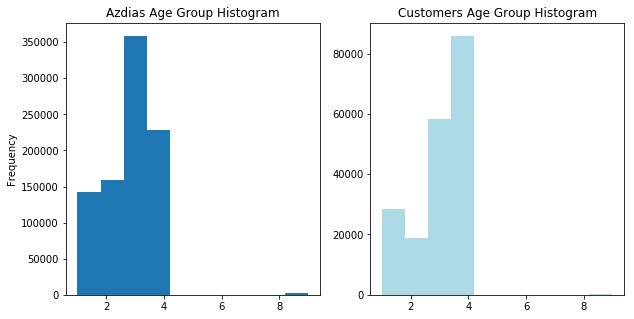

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
azdias['ALTERSKATEGORIE_GROB'].plot(kind='hist', ax = ax[0]);
customers['ALTERSKATEGORIE_GROB'].plot(kind = 'hist', color = 'lightblue' , ax = ax[1]);
ax[0].set_title('Azdias Age Group Histogram');
ax[1].set_title('Customers Age Group Histogram');
ax[1].set_ylabel('');

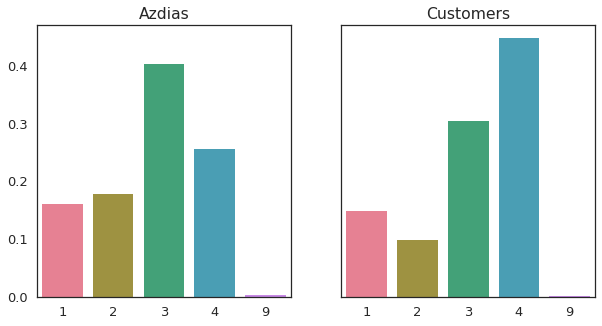

In [4]:
azdias_age_group_ratio = azdias['ALTERSKATEGORIE_GROB'].value_counts() / azdias['ALTERSKATEGORIE_GROB'].shape[0]
customers_age_group_ratio = customers['ALTERSKATEGORIE_GROB'].value_counts() / customers['ALTERSKATEGORIE_GROB'].shape[0]
sns.set(style="white", context="talk");
fig, ax = plt.subplots(1,2,sharey= True,figsize = (10,5));
sns.barplot(x = azdias_age_group_ratio.index , y = azdias_age_group_ratio.values, palette = sns.color_palette("husl", 5), ax = ax[0]);
sns.barplot(x = customers_age_group_ratio.index , y = customers_age_group_ratio.values, palette = sns.color_palette("husl", 5), ax = ax[1]);
ax[0].set_title('Azdias');
ax[1].set_title('Customers');

**性别比例**

Customers数据集中男性（代表1）的比例超过60%。

In [5]:
azdias['ANREDE_KZ'].value_counts() / azdias.shape[0]

2    0.522098
1    0.477902
Name: ANREDE_KZ, dtype: float64

In [6]:
customers['ANREDE_KZ'].value_counts() / customers.shape[0]

1    0.623568
2    0.376432
Name: ANREDE_KZ, dtype: float64

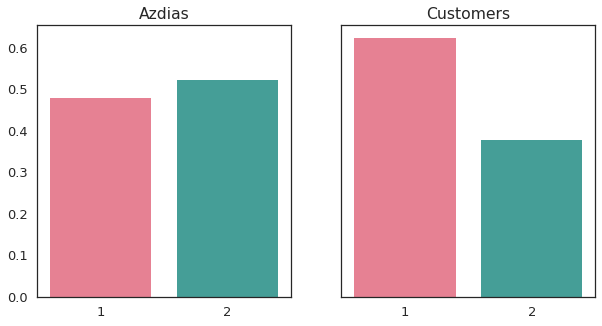

In [7]:
customers_gender = customers['ANREDE_KZ'].value_counts() / customers.shape[0]
azdias_gender = azdias['ANREDE_KZ'].value_counts() / azdias.shape[0]
sns.set(style="white", context="talk");
fig, ax = plt.subplots(1,2,sharey= True,figsize = (10,5));
sns.barplot(x = azdias_gender .index , y = azdias_gender .values, palette = sns.color_palette("husl", 2), ax = ax[0]);
sns.barplot(x = customers_gender.index , y = customers_gender.values, palette = sns.color_palette("husl", 2), ax = ax[1]);
ax[0].set_title('Azdias');
ax[1].set_title('Customers');

**分析数据集中的缺失值**

'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4'，这4个特征缺失值比例较大，可以直接舍弃。

In [8]:
#Calculate the null value ratio in azdias and customers datasets
azdias_null_ratio = (azdias.isnull().sum() / azdias.shape[0]) * 100
customers_null_ratio = (customers.isnull().sum() / customers.shape[0]) * 100

In [9]:
print("Number of Columns with null value in Azdias: {}".format(len(azdias_null_ratio[azdias_null_ratio > 0])))
print("Number of Columns with null value in Customers: {}".format(len(customers_null_ratio[customers_null_ratio > 0])))

Number of Columns with null value in Azdias: 273
Number of Columns with null value in Customers: 273


**数据在列上的缺失值分布**

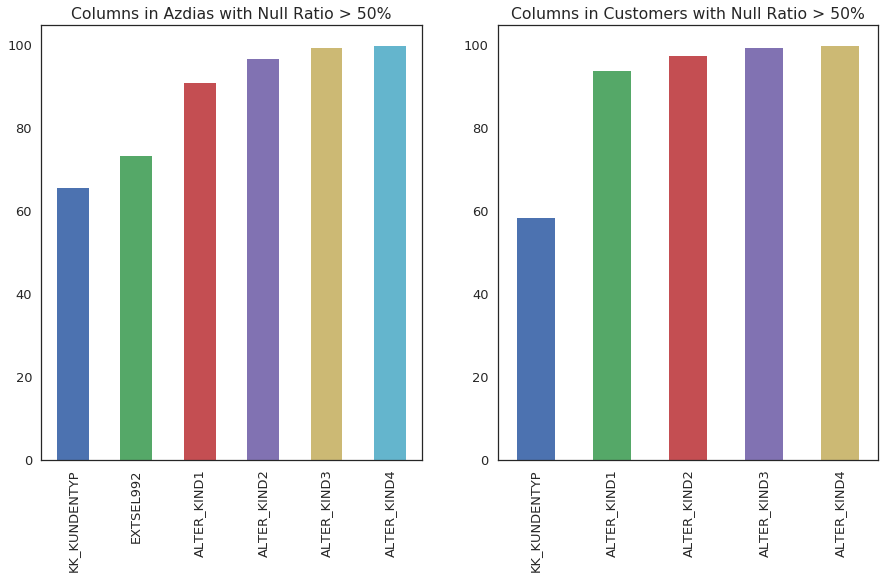

In [10]:
#Plot Features with Null Ratio greater than 50%
fig, ax = plt.subplots(1,2, figsize = (15,8))
azdias_null_ratio[azdias_null_ratio > 50].sort_values().plot(kind = 'bar', ax = ax[0]);
ax[0].set_title("Columns in Azdias with Null Ratio > 50%");
customers_null_ratio[customers_null_ratio > 50].sort_values().plot(kind = 'bar', ax = ax[1]);
ax[1].set_title("Columns in Customers with Null Ratio > 50%");

**数据在行上的缺失值分布**

**customers数据集有存在50000行数据有超过200个特征值缺失（共368个特征）**

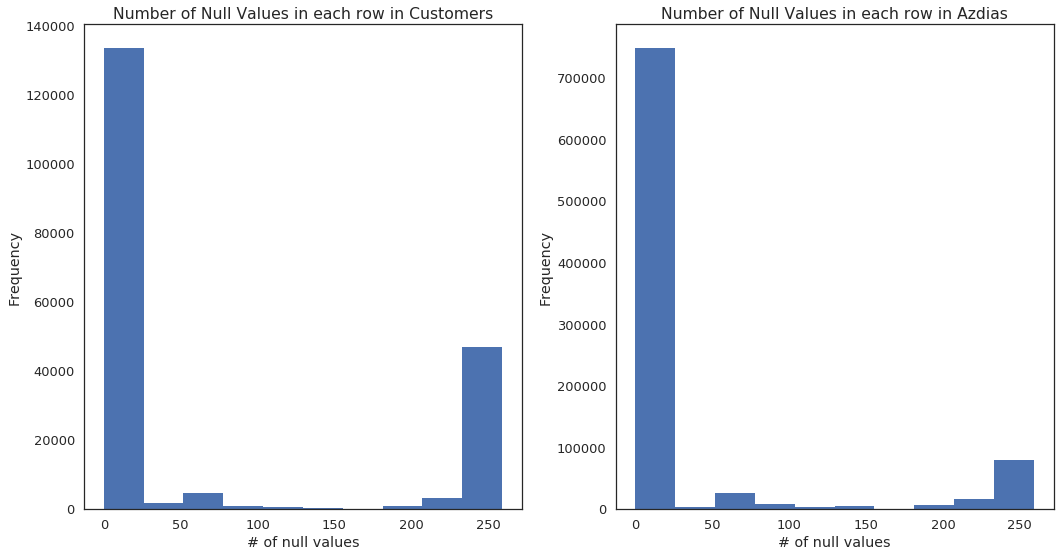

In [11]:
row_null_cust = customers.isnull().sum(axis = 1)
row_null_azdias = azdias.isnull().sum(axis = 1)
fig, ax = plt.subplots(1,2, figsize = (15,8));
row_null_cust.plot(kind = 'hist', ax = ax[0]);
row_null_azdias.plot(kind = 'hist', ax = ax[1]);
ax[0].set_xlabel('# of null values');
ax[1].set_xlabel('# of null values');
ax[0].set_title('Number of Null Values in each row in Customers');
ax[1].set_title('Number of Null Values in each row in Azdias');
plt.tight_layout();

## 处理缺失值

### 数据中Unkown的处理以及特征列数据类型的处理

**部分特征存在Null值的同时又使用 -1 、0或者9来表示Unknown数值，这些值其实实际意义为Null值**

In [3]:
#read_attributes excel sheet and values excel sheet
dias_values = pd.read_excel("DIAS Attributes - Values 2017.xlsx",skiprows = 1,usecols = "B:E").fillna(method='ffill')
dias_attributes = pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx",skiprows = 1,usecols = "B:E").fillna(method='ffill')

In [6]:
dias_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [10]:
attribute_numeric = dias_values[dias_values['Meaning'].str.contains("numeric")].reset_index(drop = True)

In [11]:
#numeric类型的特征列将使用randomforestregressor
numeric_list = attribute_numeric['Attribute'].tolist()

,Attribute,Description,Value,Meaning
0,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
1,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
2,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
3,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
4,GEBURTSJAHR,year of birth,…,numeric value


In [7]:
#values of attributes represented as unknown
attribute_unknown_values = dias_values[dias_values['Meaning'].str.contains('unknow')].reset_index(drop=True)
attribute_unknown_values['Value'] = attribute_unknown_values['Value'].apply(lambda x: x.split(',') if type(x) != int else x)

In [141]:
attribute_unknown_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",unknown
2,ALTER_HH,main age within the household,0,unknown / no main age detectable
3,ANREDE_KZ,gender,"[-1, 0]",unknown
4,BALLRAUM,distance to next urban centre,-1,unknown


In [16]:
#特征列存在Null值，同时又以-1、0或9来表示Unknown数据的列，将这些值统一处理为np.nan
for i, j in zip(attribute_unknown_values['Attribute'], attribute_unknown_values['Value']):
    if i in azdias.columns:    
        if azdias[i].isnull().sum() != 0:
            if type(j) != int:
                condition = azdias[i].isin(j)
                azdias[i].mask(condition,inplace = True)
            else:
                azdias[i].mask(azdias[i] == j,inplace = True)

In [17]:
#特征列存在Null值，同时又以-1、0或9来表示Unknown数据的列，将这些值统一处理为np.nan
for i, j in zip(attribute_unknown_values['Attribute'], attribute_unknown_values['Value']):
    if i in customers.columns:
        if customers[i].isnull().sum() != 0:
            if type(j) != int:
                condition = customers[i].isin(j)
                customers[i].mask(condition,inplace = True)
            else:
                customers[i].mask(customers[i] == j,inplace = True)

**处理后数据集中Null值的分布**

1. 对比处理 -1、0、9这些Unknown之前，又有新的特征缺失值比例超过50%
2. 可以舍弃的特征有ALTER_KIND1 - ALTER_KIND4、TITLE_KZ
3. 一些特征列的缺失值数据比例上升

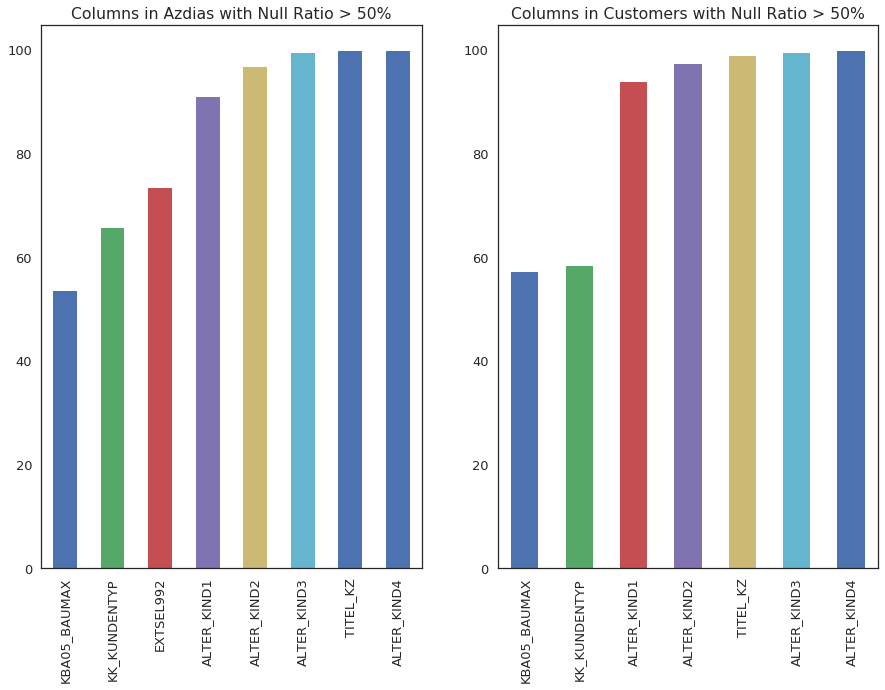

In [18]:
#Calculate the null value ratio in azdias and customers datasets
azdias_null_ratio = (azdias.isnull().sum() / azdias.shape[0]) * 100
customers_null_ratio = (customers.isnull().sum() / customers.shape[0]) * 100
#Plot Features with Null Ratio greater than 50%
fig, ax = plt.subplots(1,2, figsize = (15,10))
azdias_null_ratio[azdias_null_ratio > 50].sort_values().plot(kind = 'bar', ax = ax[0]);
ax[0].set_title("Columns in Azdias with Null Ratio > 50%");
customers_null_ratio[customers_null_ratio > 50].sort_values().plot(kind = 'bar', ax = ax[1]);
ax[1].set_title("Columns in Customers with Null Ratio > 50%");

**对Customers数据集中缺失值的特征使用随机森林进行补全 （去除缺失值比例超过90%的特征）**

1. 去除缺失值比例过高的特征列
2. 处理数据集中的X、x为np.nan
3. 将特征按缺失值数量从小到大排序，首先取用无缺失值的特征，从缺失值最少的特征开始，使用随机森林算法补全缺失值，并加入补全的特征。

In [21]:
customers_cleaned = customers.drop(columns = ['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE','ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1']).set_index('LNR')
#replace any X, XX with np.nan
customers_cleaned.mask(customers_cleaned.isin(['X','XX']),inplace = True)

In [22]:
#将数据集中Object类型的纯数字的特征列转化为Float
#Convert digit from object to float type
object_columns = customers_cleaned.dtypes[customers_cleaned.dtypes == 'object'].index.tolist()
col_to_dummy = []
for col in object_columns:
    try:
        customers_cleaned[col] = customers_cleaned[col].astype('float64')
    except ValueError:
        col_to_dummy.append(col)

In [23]:
#独热编码数据集中str的特征列
#one hot encoding columns contain non-digit string
for col in col_to_dummy:
    dummied = pd.get_dummies(customers_cleaned[col], prefix = col, drop_first = True)
    customers_cleaned = pd.concat([customers_cleaned, dummied], axis = 1)
    customers_cleaned.drop(columns = col, inplace = True)

In [24]:
customers_cleaned.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_W,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,CUSTOMER_GROUP_SINGLE_BUYER
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
9628,-1,9.0,11.0,NaN,NaN,NaN,0.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,1,1
143872,-1,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
143873,1,1.0,8.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
143874,-1,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,...,0,0,0,0,0,0,1,0,1,0


In [25]:
#将特征列按缺失值数量从少到多排序
#Sort Feature Columns by the number of null values in ascending order
sorted_col = customers_cleaned.isnull().sum(axis = 0).sort_values().index.tolist()

In [26]:
#提取无缺失值的特征放入zero_null_col中，有缺失值的特征放入null_col中
#Split features columns into zero_null_col and null_col based on having null value or not
zero_null_col = []
nul_col = []
for i in sorted_col:
    if customers_cleaned[i].isnull().sum() == 0:
        zero_null_col.append(i)
    else:
        nul_col.append(i)

In [27]:
%%time
#随机森林算法补全缺失的特征值
#RandomForest to fill in null values

for index, i in enumerate(nul_col):
    #遍历null_col,将数据集分为Train和Predict,Predict数据集包含所有该特征列有缺失值的行
    Train_df = customers_cleaned[~customers_cleaned[i].isnull()]
    Predict_df = customers_cleaned[customers_cleaned[i].isnull()]
    Y_train = Train_df.loc[:, i]
    X_train = Train_df.loc[:,zero_null_col]
    X_predict = Predict_df.loc[:,zero_null_col]
    
    if i in numeric_list:
    #限制每棵树的最大深度为10加快计算速度
        rf = RandomForestRegressor(n_estimators=5, max_depth = 10)
    else:
        rf = RandomForestClassifier(n_estimators=5, max_depth = 10)
    rf.fit(X_train, Y_train)
    Y_predict = rf.predict(X_predict)
    
    #使用随机森林预测的值补全缺失值
    customers_cleaned.loc[customers_cleaned[i].isnull(), i] = Y_predict
    #将完成补全缺失值的列加入zero_null_col中以便下一次循环或许可以使用这个特征
    zero_null_col.append(i)
    #每一轮补全完成时打印
    print("Round {} Finished".format(index + 1))
    print("------------------------\n")

print('Finished')

Round 1 Finished
------------------------

Round 2 Finished
------------------------

Round 3 Finished
------------------------

Round 4 Finished
------------------------

Round 5 Finished
------------------------

Round 6 Finished
------------------------

Round 7 Finished
------------------------

Round 8 Finished
------------------------

Round 9 Finished
------------------------

Round 10 Finished
------------------------

Round 11 Finished
------------------------

Round 12 Finished
------------------------

Round 13 Finished
------------------------

Round 14 Finished
------------------------

Round 15 Finished
------------------------

Round 16 Finished
------------------------

Round 17 Finished
------------------------

Round 18 Finished
------------------------

Round 19 Finished
------------------------

Round 20 Finished
------------------------

Round 21 Finished
------------------------

Round 22 Finished
------------------------

Round 23 Finished
-----------------------

In [28]:
print("Number of Null Values:{}".format(customers_cleaned.isnull().sum().sum()))

Number of Null Values:0


## 将上述清洗数据、随机森林填充缺失值的方法写成函数并清洗Azdias和Customers数据集

**对Numeric类型的特征列使用Randomforest-regressor；object类型使用Randomforest - classifier**

In [5]:
def RandomForest_Fill_Null(df, drop_threshold = 70, n_estimators = 5, max_depths = 10):
    """
    INPUT: 
    df - Dataframe
    drop_threhold - null_value_ratio
    n_estimators - Number of Tree
    max_depths - Depths of each tree
    
    OUTPUT:
    df_cleaned: Cleaned and Null values filled Data
    """
    
    #读取Attributes - Values表格
    dias_values = pd.read_excel("DIAS Attributes - Values 2017.xlsx",skiprows = 1,usecols = "B:E").fillna(method='ffill')
    #获取Numeric类型的特征列
    attribute_numeric = dias_values[dias_values['Meaning'].str.contains("numeric")].reset_index(drop = True)
    numeric_features = attribute_numeric['Attribute'].tolist()
    #获取各特征表示Unknown的数字
    attribute_unknown_values = dias_values[dias_values['Meaning'].str.contains('unknow')].reset_index(drop=True)
    #部分特征有2个string类型中间以逗号连接的数字表示Unknown，将其split分开，得到两个数字组成的列表 
    attribute_unknown_values['Value'] = attribute_unknown_values['Value'].apply(lambda x: x.split(',') if type(x) != int else x)
    
    #对于存在缺失值且有使用数字-1、0、9表示Unknown的列，将这些数字替换为np.nan，其余无缺失值的列，默认有数字表示缺失值。
    for i, j in zip(attribute_unknown_values['Attribute'], attribute_unknown_values['Value']):
        if i in df.columns:
            if df[i].isnull().sum() != 0:
                if type(j) != int:
                    condition = df[i].isin(j)
                    df[i].mask(condition,inplace = True)
                else:
                    df[i].mask(df[i] == j,inplace = True)
                    
    #因数据集大，直接替换所有X和XX耗时长，把数据集分成9块清理后再Concat                
    chunk = np.linspace(0, df.shape[0], 10, dtype = int)
    df_to_concat = []
    #循环所有chunk
    for i in range(len(chunk)-1):
        chunk_df = df.iloc[chunk[i]:chunk[i+1],:]
        chunk_df.mask(chunk_df.isin(['X','XX']), inplace = True)
        #处理好的chunk_df添加到列表中
        df_to_concat.append(chunk_df)
        print('Chunk {} Finished'.format(i+1))
        
    #重新连接组合数据集
    df_cleaned = pd.concat(df_to_concat,axis = 0)
    del df_to_concat #释放内存
    print("Replace X and XX with np.nan Finished")
    
    df_cleaned_null_ratio = ((df_cleaned.isnull().sum()) / df_cleaned.shape[0]) * 100
    #去掉缺失值比例高于阈值的所有特征列
    columns_to_drop = df_cleaned_null_ratio[df_cleaned_null_ratio >= drop_threshold].index.tolist()
    #q去掉2个不明的特征列
    columns_to_drop.append('D19_LETZTER_KAUF_BRANCHE')
    columns_to_drop.append('EINGEFUEGT_AM')
    df_cleaned = df_cleaned.drop(columns = columns_to_drop).set_index('LNR')
    print("Drop columns with high null value ratio Finished")
    
    #所有需要处理的object类型的特征列，分为两块：纯数字的转化为Float类型；有字符的添加到col_to_dummy后续使用one hot encoding
    object_columns = df_cleaned.dtypes[df_cleaned.dtypes == 'object'].index.tolist()
    col_to_dummy = []
    for col in object_columns:
        try:
            df_cleaned[col] = df_cleaned[col].astype('float64')
        except ValueError:
            col_to_dummy.append(col)
    print("Assign Type to Float Finished")
    
    #dummied_list存放one hot encoding后的特征列
    dummied_list = []
    for col in col_to_dummy:
        dummied = pd.get_dummies(df_cleaned[col], prefix = col)
        dummied = dummied.astype("Float64")
        dummied_list.append(dummied)
        print("column {} to dummy finished".format(col))
    
    #将独热编码后的特征列与原数据集合并，并drop掉原来的特征列
    dummied_df = pd.concat(dummied_list, axis = 1)
    df_cleaned = pd.concat([df_cleaned, dummied_df], axis = 1,copy = False)
    del dummied_df #释放内存
    df_cleaned.drop(columns = col_to_dummy, inplace = True)
    print("To Dummy Finished")
    
    #根据缺失值的数量从小到大对所有特征列排序
    sorted_col = df_cleaned.isnull().sum(axis = 0).sort_values().index.tolist()
    #zero_null_col存放缺失值为0的特征列；nul_col存放有缺失值的特征列（缺失值数量从小到大）
    zero_null_col = []
    nul_col = []
    for i in sorted_col:
        if df_cleaned[i].isnull().sum() == 0:
            zero_null_col.append(i)
        else:
            nul_col.append(i)
    print("Split All Feature Columns into two lists finished")     
            
    for index, i in enumerate(nul_col):
        #遍历nul_col,将数据集分为Train和Predict,Predict数据集包含所有该特征列有缺失值的行
        Train_df = df_cleaned[~df_cleaned[i].isnull()]
        Predict_df = df_cleaned[df_cleaned[i].isnull()]
        Y_train = Train_df.loc[:, i]
        X_train = Train_df.loc[:,zero_null_col]
        X_predict = Predict_df.loc[:,zero_null_col]
        
        #Numeric类型的特征使用随机森林回归，其他类型特征使用随机森林分类,默认每棵树的最大深度为10，树的数目为5，加快计算速度
        if i in numeric_features:
            rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depths, random_state = 18)
        else:
            rf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depths, random_state = 18)
        #Fit数据集
        rf.fit(X_train, Y_train)
        Y_predict = rf.predict(X_predict)

        #使用随机森林预测的值补全缺失值
        df_cleaned.loc[df_cleaned[i].isnull(), i] = Y_predict
        #将完成补全缺失值的列加入zero_null_col中以便下一次循环或许可以使用这个特征
        zero_null_col.append(i)
        #每一轮补全完成时打印
        print("RF Fill Null Round {} Finished".format(index + 1))
        print("------------------------\n")

    print('Finished')
    return df_cleaned

In [25]:
%%time
#去掉缺失值超过70%的特征列，限制树的数目和深度加快计算速度
cleaned_customers = RandomForest_Fill_Null(customers, 70, 5, 10)

Chunk 1 Finished
Chunk 2 Finished
Chunk 3 Finished
Chunk 4 Finished
Chunk 5 Finished
Chunk 6 Finished
Chunk 7 Finished
Chunk 8 Finished
Chunk 9 Finished
Replace X and XX with np.nan Finished
Drop columns with high null value ratio Finished
Assign Type to Float Finished
column CAMEO_DEU_2015 to dummy finished
column OST_WEST_KZ to dummy finished
column PRODUCT_GROUP to dummy finished
column CUSTOMER_GROUP to dummy finished
To Dummy Finished
Split All Feature Columns into two lists finished
RF Fill Null Round 1 Finished
------------------------

RF Fill Null Round 2 Finished
------------------------

RF Fill Null Round 3 Finished
------------------------

RF Fill Null Round 4 Finished
------------------------

RF Fill Null Round 5 Finished
------------------------

RF Fill Null Round 6 Finished
------------------------

RF Fill Null Round 7 Finished
------------------------

RF Fill Null Round 8 Finished
------------------------

RF Fill Null Round 9 Finished
------------------------

RF

**去除掉Azdias数据集中所有缺失值比例超过50%的行，减少数据的处理量**

In [3]:
row_null_azdias = azdias.isnull().sum(axis = 1)
row_null_ratio_azdias = row_null_azdias / azdias.shape[1]
row_to_drop = row_null_ratio_azdias[row_null_ratio_azdias >= 0.5].index.tolist()
azdias_drop = azdias.drop(index = row_to_drop).reset_index(drop=True)
print(f'Row Number of Azdias: {azdias.shape}')
print(f'Row Number of Azdias After Cleaned: {azdias_drop.shape}')

Row Number of Azdias: (891221, 366)
Row Number of Azdias After Cleaned: (791988, 366)


### 使用随机森林对Azdias_drop缺失值进行填充
#### 1.使用所有数据，耗费时间1个小时以上；2.可以将数据分成三块，牺牲精度，减少处理时间。

**使用全量数据**

In [6]:
%%time
#直接处理全量数据，去掉缺失值超过70%的特征列，限制树的数目和深度加快计算速度
cleaned_azdias_new = RandomForest_Fill_Null(azdias_drop,70,5,10)

Chunk 1 Finished
Chunk 2 Finished
Chunk 3 Finished
Chunk 4 Finished
Chunk 5 Finished
Chunk 6 Finished
Chunk 7 Finished
Chunk 8 Finished
Chunk 9 Finished
Replace X and XX with np.nan Finished
Drop columns with high null value ratio Finished
Assign Type to Float Finished
column CAMEO_DEU_2015 to dummy finished
column OST_WEST_KZ to dummy finished
To Dummy Finished
Split All Feature Columns into two lists finished
RF Fill Null Round 1 Finished
------------------------

RF Fill Null Round 2 Finished
------------------------

RF Fill Null Round 3 Finished
------------------------

RF Fill Null Round 4 Finished
------------------------

RF Fill Null Round 5 Finished
------------------------

RF Fill Null Round 6 Finished
------------------------

RF Fill Null Round 7 Finished
------------------------

RF Fill Null Round 8 Finished
------------------------

RF Fill Null Round 9 Finished
------------------------

RF Fill Null Round 10 Finished
------------------------

RF Fill Null Round 11 Fi

In [7]:
cleaned_azdias_new.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
910225,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
910226,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
910241,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
910244,3,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**将数据集分为三块分次处理后再合并**

In [31]:
azdias_split = []
row_index = np.linspace(0, azdias_drop.shape[0], 4,dtype = int)
for k in range(len(row_index)-1):
    print("Row:{} to {} are being processed".format(row_index[k], row_index[k+1]))
    azdias_split.append(RandomForest_Fill_Null(azdias_drop.iloc[row_index[k]: row_index[k+1], :], 70,3, 5))
    print("Row:{} to {} are cleaned\n".format(row_index[k], row_index[k+1]))

Row:0 to 263996 are being processed
Chunk 1 Finished
Chunk 2 Finished
Chunk 3 Finished
Chunk 4 Finished
Chunk 5 Finished
Chunk 6 Finished
Chunk 7 Finished
Chunk 8 Finished
Chunk 9 Finished
Replace X and XX with np.nan Finished
Drop columns with high null value ratio Finished
Assign Type to Float Finished
column CAMEO_DEU_2015 to dummy finished
column OST_WEST_KZ to dummy finished
To Dummy Finished
Split All Feature Columns into two lists finished
RF Fill Null Round 1 Finished
------------------------

RF Fill Null Round 2 Finished
------------------------

RF Fill Null Round 3 Finished
------------------------

RF Fill Null Round 4 Finished
------------------------

RF Fill Null Round 5 Finished
------------------------

RF Fill Null Round 6 Finished
------------------------

RF Fill Null Round 7 Finished
------------------------

RF Fill Null Round 8 Finished
------------------------

RF Fill Null Round 9 Finished
------------------------

RF Fill Null Round 10 Finished
--------------

In [33]:
#合并数据集
cleaned_azdias = pd.concat(azdias_split, axis = 0)

使用全量数据清洗和随机森林填充缺失值

In [8]:
print(f'Shape of Azdias: {azdias.shape}')
print(f"Shape of Azdias High-Null-Ratio Rows Dropped : {azdias_drop.shape}")
print(f"Shape of Cleaned and Na-Filled Azdias: {cleaned_azdias_new.shape}")

Shape of Azdias: (891221, 366)
Shape of Azdias High-Null-Ratio Rows Dropped : (791988, 366)
Shape of Cleaned and Na-Filled Azdias: (791988, 402)


In [13]:
print(f' Shape of Customers: {customers.shape}')
print(f" Shape of Cleaned and Na-Filled Customers: {cleaned_customers.shape}")

 Shape of Customers: (191652, 369)
 Shape of Cleaned and Na-Filled Customers: (191652, 408)


In [10]:
#把清洗好、缺失值填充完毕的cleaned_azdias存为pickle
cleaned_azdias_new.to_pickle("Cleaned_Azdias_New.pkl")

In [27]:
#把清洗好、缺失值填充完毕的cleaned_customers存为pickle
cleaned_customers.to_pickle("Cleaned_Customers_New.pkl")

-------------------------------------------

## 第1部分：顾客分类报告

项目报告的主体部分应该就是这部分。在这个部分，你应该使用非监督学习技术来刻画公司已有顾客和德国一般人群的人口统计数据的关系。这部分做完后，你应该能够描述一般人群中的哪一类人更可能是邮购公司的主要核心顾客，哪些人则很可能不是。

**在第0部分处理了Azdias和Customers数据集，去掉了缺失值比例过高的特征列，使用随机森林算法填充了其余列的缺失值**

在使用非监督学习算法之前，首先对数据集进行标准化处理，使用Sklearn的StandardScaler类

In [11]:
azdias_cleaned = pd.read_pickle("Cleaned_Azdias_New.pkl")
customers_cleaned = pd.read_pickle("Cleaned_Customers_New.pkl")

Azdias和customers数据集中存在各自独有的特征列，在进行非监督学习时，使用azdias和customers共有的列

In [15]:
azdias_cleaned_features = set(azdias_cleaned.columns)
customers_cleaned_features = set(customers_cleaned.columns)
intersected_features = list(azdias_cleaned_features.intersection(customers_cleaned_features))
len(intersected_features)

401

In [16]:
azdias_cleaned = azdias_cleaned[intersected_features]
customers_cleaned = customers_cleaned[intersected_features]

In [17]:
scaler = StandardScaler()
scaler.fit(azdias_cleaned)
azdias_scaled = scaler.transform(azdias_cleaned.astype('Float64'))

In [18]:
azdias_scaled_df = pd.DataFrame(azdias_scaled, index = azdias_cleaned.index, columns = azdias_cleaned.columns)
azdias_scaled_df.head()

,KBA05_KW2,KBA13_HALTER_66,KBA05_MAXVORB,KBA13_CCM_3000,KBA13_SEG_KOMPAKTKLASSE,OST_WEST_KZ_O,KBA13_ALTERHALTER_30,KBA13_SEG_MITTELKLASSE,FINANZ_SPARER,KBA05_ALTER1,...,KBA05_ANHANG,PLZ8_ANTG1,CAMEO_DEU_2015_4D,KBA13_CCM_3001,KBA13_KRSHERST_BMW_BENZ,KBA05_BAUMAX,KBA13_SITZE_5,CAMEO_INTL_2015,MOBI_REGIO,CAMEO_DEU_2015_8C
LNR,,,,,,,,,,,,,,,,,,,,,
910220,0.012558,0.837880,1.264632,-1.898164,2.020011,-0.51786,0.018856,-0.057596,1.537943,0.907085,...,-1.021652,-0.262548,-0.104362,1.566534,-0.081769,1.411625,0.148479,1.103993,-1.401074,-0.201579
910225,-0.961555,-0.094259,-1.427581,0.302841,-1.924419,-0.51786,0.018856,-1.036075,0.864915,0.055241,...,-1.021652,0.770931,-0.104362,1.566534,-0.081769,-0.892574,-0.800277,-0.820258,-0.012173,-0.201579
910226,0.986670,-1.026399,-0.081475,0.302841,1.033903,-0.51786,-0.926337,0.920882,-0.481139,0.055241,...,0.053333,-0.262548,-0.104362,1.566534,0.912462,-0.892574,0.148479,-1.675480,0.682277,-0.201579
910241,-0.961555,-0.094259,-1.427581,1.770178,0.047796,-0.51786,0.018856,-1.036075,0.191888,-1.648447,...,-1.021652,-0.262548,-0.104362,1.566534,-0.081769,-0.892574,0.148479,0.533845,-0.012173,-0.201579
910244,1.960783,-0.094259,-1.427581,0.302841,-0.938312,-0.51786,-0.926337,-0.057596,-1.154167,-1.648447,...,0.053333,-0.262548,-0.104362,0.904604,-0.081769,-0.892574,0.148479,1.317799,0.682277,4.960843


In [20]:
azdias_scaled_df.to_pickle("Scaled_Azdias_df.pkl")

### 使用PCA对数据进行降维，首先保留所有component，来找到合适的n_component参数

In [2]:
azdias_scaled_df = pd.read_pickle("Scaled_Azdias_df.pkl")

In [21]:
pca_azdias = PCA(random_state = 18)
pca_azdias.fit(azdias_scaled_df);
azdias_explained_vr = np.cumsum(pca_azdias.explained_variance_ratio_)
#azdias_explained_vr
print(f"Total Components : {azdias_explained_vr.shape}")
print(f'Total {np.argwhere(azdias_explained_vr >=0.9)[0][0]} Principal Components Can Explain 90% Variance')

Total Components : (401,)
Total 208 Principal Components Can Explain 90% Variance


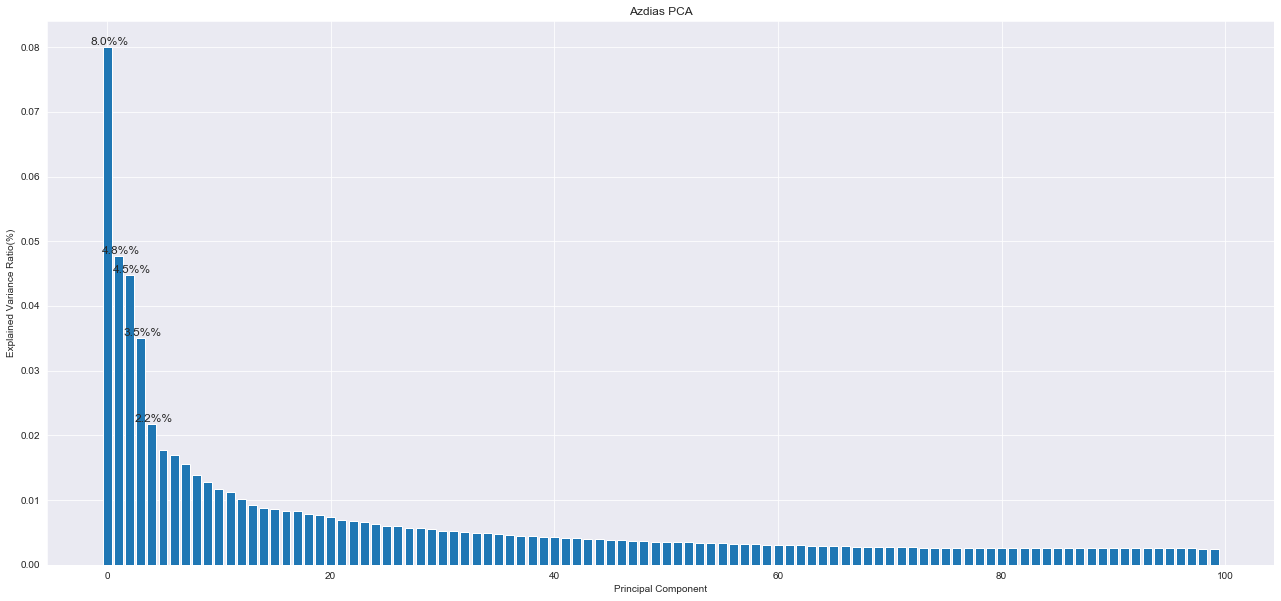

In [22]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1, figsize =(22,10));
value_azd = pca_azdias.explained_variance_ratio_[:100]
ax.bar(range(100), value_azd);
for i in range(5):
    ax.annotate( "{:.1%}%".format(value_azd[i]), (i+0.2, value_azd[i]), va='bottom',ha='center',fontsize=12);
ax.set_title("Azdias PCA");
ax.set_xlabel("Principal Component");
ax.set_ylabel("Explained Variance Ratio(%)");

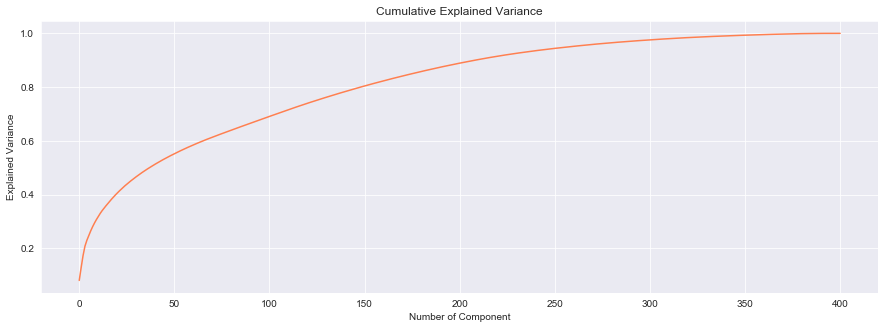

In [23]:
fig, ax = plt.subplots(1,1, figsize = (15,5))
ax.plot(azdias_explained_vr, color = 'coral');
ax.set_xlabel("Number of Component");
ax.set_ylabel("Explained Variance");
ax.set_title("Cumulative Explained Variance");

### 确定保留208个主成分

**分析各特征对主成分的解释度**

In [24]:
#自定义一个函数返回fit数据集后的pca对象和transform后的数据集
def perform_pca(df, n_components = 208):
    pca = PCA(n_components = n_components, random_state=18)
    pca.fit(df)
    
    return pca, pca.transform(df)

In [25]:
%%time
#保留208个主成分对azdias数据集进行PCA降维
pca_azd, azdias_after_pca = perform_pca(azdias_scaled_df, 208)

Wall time: 1min 15s


In [26]:
index = ['PC{}'.format(i) for i in range(1,len(pca_azd.components_)+1)]
#Index: 208个主成分 Column: 原特征，Value: 权重
pca_azdias_df = pd.DataFrame(pca_azd.components_, columns = azdias_cleaned.columns, index = index)

**对主成分1正影响最大的前5个特征**

In [27]:
pca_azdias_df.loc['PC1',:].sort_values(ascending = False)[:5]

MOBI_REGIO        0.134156
PLZ8_ANTG1        0.124967
KBA13_ANTG1       0.123970
KBA05_ANTG1       0.123901
LP_STATUS_FEIN    0.123472
Name: PC1, dtype: float64

**对主成分1负影响最大的前5个特征**

In [28]:
pca_azdias_df.loc['PC1',:].sort_values(ascending = False)[-5:]

KBA05_BAUMAX      -0.119751
KBA13_ANTG4       -0.120080
CAMEO_DEUG_2015   -0.120537
KBA13_ANTG3       -0.123454
PLZ8_ANTG3        -0.124209
Name: PC1, dtype: float64

In [29]:
np.cumsum(pca_azd.explained_variance_ratio_)[4]*100

22.928585874144087

### 使用K-means算法对PCA降维后的数据进行聚类
#### 首先使用MiniBatchKmeans计算各聚类类别的分数，选取最合适的聚类类别数

In [30]:
azdias_after_pca.shape[0]//3

263996

In [33]:
%%time
#对不同的聚类大小使用calinski_harabaz进行比较分数，使用MinibatchKMeans加快计算速度
ch_score = []
inertia_score = []
db_score = []
for n in range(2,21):
    kmeans = MiniBatchKMeans(n_clusters = n, random_state = 42,batch_size = 270000)
    pred = kmeans.fit_predict(azdias_after_pca)
    ch_score.append((n, calinski_harabasz_score(azdias_after_pca, pred)))
    inertia_score.append((n, kmeans.inertia_))
    db_score.append((n, davies_bouldin_score(azdias_after_pca, pred)))
    print(f'K-Means with {n} Clusters Finished')
    del kmeans
    del pred
print("Finished")

K-Means with 2 Clusters Finished
K-Means with 3 Clusters Finished
K-Means with 4 Clusters Finished
K-Means with 5 Clusters Finished
K-Means with 6 Clusters Finished
K-Means with 7 Clusters Finished
K-Means with 8 Clusters Finished
K-Means with 9 Clusters Finished
K-Means with 10 Clusters Finished
K-Means with 11 Clusters Finished
K-Means with 12 Clusters Finished
K-Means with 13 Clusters Finished
K-Means with 14 Clusters Finished
K-Means with 15 Clusters Finished
K-Means with 16 Clusters Finished
K-Means with 17 Clusters Finished
K-Means with 18 Clusters Finished
K-Means with 19 Clusters Finished
K-Means with 20 Clusters Finished
Finished
Wall time: 33min 33s


### 根据calinski_harabaz分数、Inertia（样本距离聚类中心之和）和davies_bouldin分数选择最合适的Cluster数目
1. calinski_harabaz分数越大，聚类效果越好，分数越小表示组间协方差很小。
2. Inertia和davies_bouldin分数越小，聚类效果越好。
3. 根据三个指标，Cluser选择8或者11，聚类效果相对较好。

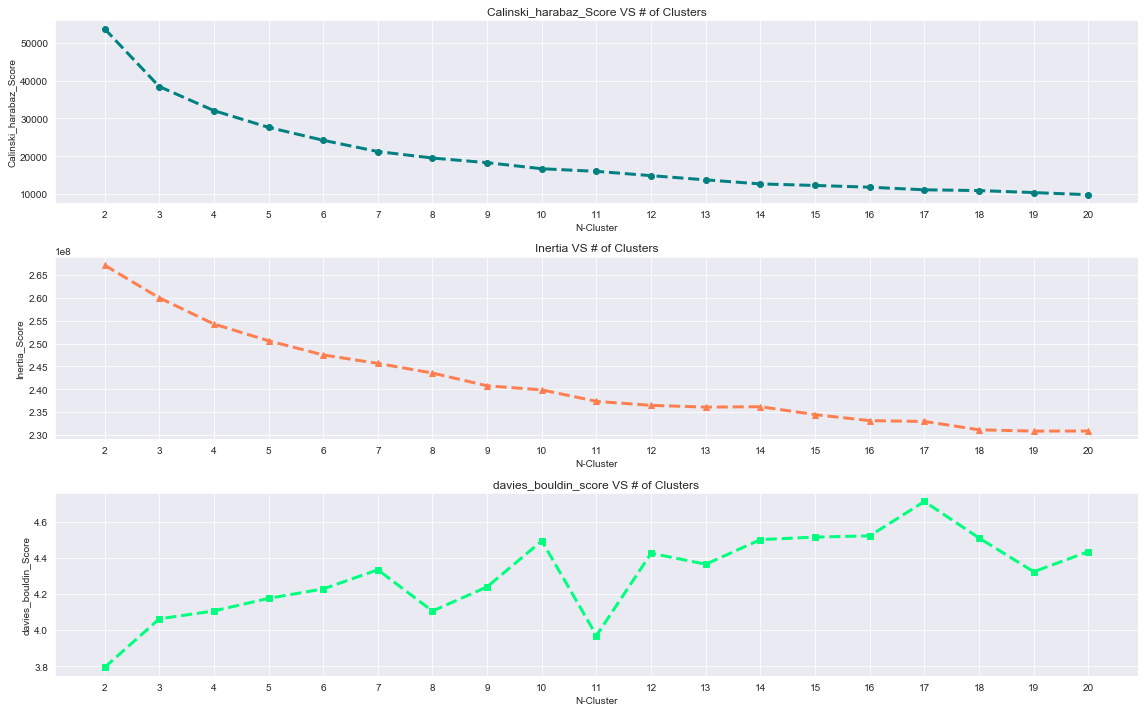

In [35]:
ch = [i[1] for i in ch_score]
inertia = [i[1] for i in inertia_score]
db = [i[1] for i in db_score]
idx = [str(i[0]) for i in ch_score]
sns.set_style('darkgrid')
fig, ax = plt.subplots(3,1, figsize = (16,10));
ax[0].plot(idx, ch, linestyle='--',linewidth=3,marker='o',color='teal');
ax[0].set_xlabel("N-Cluster")
ax[0].set_ylabel("Calinski_harabaz_Score");
ax[0].set_title("Calinski_harabaz_Score VS # of Clusters");

ax[1].plot(idx, inertia, linestyle='--',linewidth=3,marker='^',color='coral');
ax[1].set_xlabel("N-Cluster")
ax[1].set_ylabel("Inertia_Score");
ax[1].set_title("Inertia VS # of Clusters");

ax[2].plot(idx, db, linestyle='--',linewidth=3,marker='s',color='springgreen');
ax[2].set_xlabel("N-Cluster")
ax[2].set_ylabel("davies_bouldin_Score");
ax[2].set_title("davies_bouldin_score VS # of Clusters");
plt.tight_layout();

### 确定聚类类别数，使用Kmeans算法分别计算聚类类别数为8或者11的评价指标分数

In [36]:
#定义聚类类别为8和11的Kmeans
kmeans_8 = KMeans(n_clusters = 8, random_state = 42)
kmeans_11 = KMeans(n_clusters=11, random_state = 42)

In [37]:
#Fit数据集
kmeans_8.fit(azdias_after_pca)
kmeans_11.fit(azdias_after_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [38]:
#保存kmeans模型
joblib.dump(kmeans_8, 'kmeans_8_clusters.pkl')

['kmeans_8_clusters.pkl']

In [39]:
joblib.dump(kmeans_11, 'kmeans_11_clusters.pkl')

['kmeans_11_clusters.pkl']

In [40]:
pred_8 = kmeans_8.predict(azdias_after_pca)
pred_11 = kmeans_11.predict(azdias_after_pca)

### 综合3个指标，最终将聚类类别选定为8

In [41]:
print("8_Clusters_CH_Score: {}".format(calinski_harabasz_score(azdias_after_pca,pred_8)))
print("11_Clusters_CH_Score: {}".format(calinski_harabasz_score(azdias_after_pca, pred_11)))

8_Clusters_CH_Score: 20580.518408236443
11_Clusters_CH_Score: 16397.18378623247


In [43]:
print("8_Clusters_davies_bouldin_Score: {}".format(davies_bouldin_score(azdias_after_pca,pred_8)))
print("11_Clusters_davies_bouldin_Score: {}".format(davies_bouldin_score(azdias_after_pca, pred_11)))

8_Clusters_davies_bouldin_Score: 3.8856592433968427
11_Clusters_davies_bouldin_Score: 3.951777441753738


In [44]:
print("8_Clusters_Inertia_Score: {}".format(kmeans_8.inertia_))
print("11_Clusters_Inertia_Score: {}".format(kmeans_11.inertia_))

8_Clusters_Inertia_Score: 241185851.0675346
11_Clusters_Inertia_Score: 236162873.75928646


In [45]:
#得到azdias数据集聚类后的标签
azdias_clustered= kmeans_8.predict(azdias_after_pca)
azdias_clustered = pd.DataFrame(azdias_clustered, columns = ['Azdias_Cluster'])

In [47]:
#用scaler、pca_azd和kmeans_8拟合数据集customers_cleaned
customers_pca = pca_azd.transform(scaler.transform(customers_cleaned))
customers_clustered = kmeans_8.predict(customers_pca)
customers_clustered = pd.DataFrame(customers_clustered, columns = ['Customers_Cluster'])

In [48]:
customers_clustered.head()

,Customers_Cluster
0,1
1,1
2,0
3,1
4,5


In [49]:
azdias_clustered['Azdias_Cluster'].value_counts()

7    130797
1    125175
2    117759
0    106586
3     96654
6     76893
4     70283
5     67841
Name: Azdias_Cluster, dtype: int64

In [50]:
customers_clustered['Customers_Cluster'].value_counts()

0    60803
1    46342
7    40580
4    29720
5     5490
6     3714
3     2758
2     2245
Name: Customers_Cluster, dtype: int64

In [51]:
clustering = pd.concat([azdias_clustered['Azdias_Cluster'].value_counts(), customers_clustered['Customers_Cluster'].value_counts()], axis = 1)
clustering = clustering.fillna(0).astype(int).reset_index().rename(columns = {'index' : 'cluster'})
clustering['Difference_Ratio'] = (clustering['Azdias_Cluster'] / clustering['Azdias_Cluster'].sum())*100 - (clustering['Customers_Cluster'] / clustering['Customers_Cluster'].sum())*100

In [52]:
clustering['azdias_ratio'] = (clustering['Azdias_Cluster'] / clustering['Azdias_Cluster'].sum())*100
clustering['customers_ratio'] = (clustering['Customers_Cluster'] / clustering['Customers_Cluster'].sum())*100

In [53]:
clustering

,cluster,Azdias_Cluster,Customers_Cluster,Difference_Ratio,azdias_ratio,customers_ratio
0,0,106586,60803,-18.267700,13.458032,31.725732
1,1,125175,46342,-8.375121,15.805164,24.180285
2,2,117759,2245,13.697392,14.868786,1.171394
3,3,96654,2758,10.764906,12.203973,1.439067
4,4,70283,29720,-6.633023,8.874251,15.507274
5,5,67841,5490,5.701346,8.565913,2.864567
6,6,76893,3714,7.770972,9.708859,1.937887
7,7,130797,40580,-4.658771,16.515023,21.173794


**可视化结果表明：**
1. Azdias数据集中，各类别的比例相对比较平均，而Customers数据集中的多数被聚类为了0、1、4、7类别
2. 其余类别customers数据集中只占很小的比例

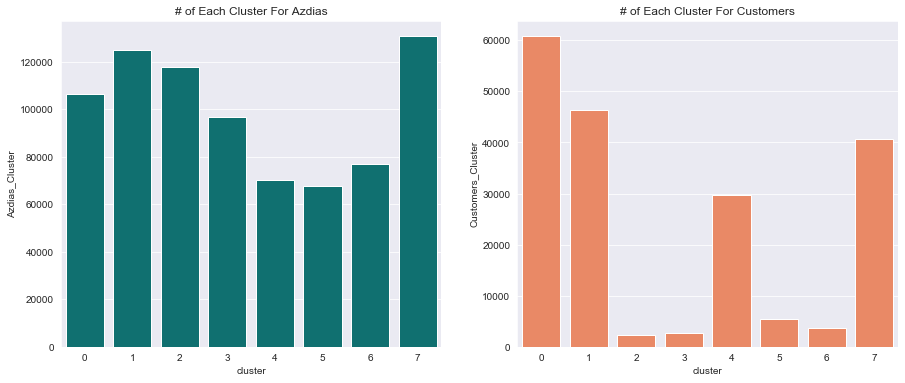

In [79]:
# 可视化聚类情况
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,2,figsize = (15,6))
sns.barplot(x = 'cluster' , y = 'Azdias_Cluster', data = clustering, color = 'teal', ax = ax[0]);
ax[0].set_title("# of Each Cluster For Azdias");
sns.barplot(x = 'cluster', y = 'Customers_Cluster', data = clustering, color = 'coral', ax = ax[1]);
ax[1].set_title("# of Each Cluster For Customers");

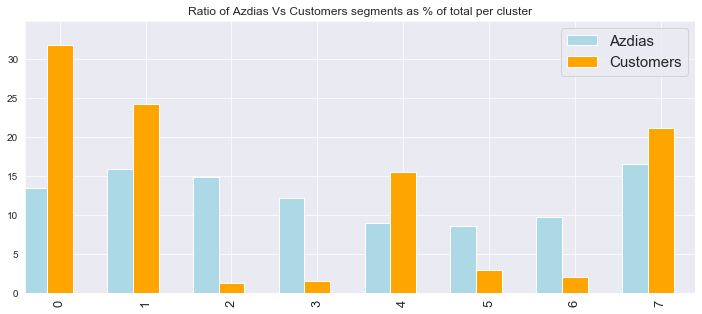

In [57]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = clustering['azdias_ratio'].plot(width=-0.3,align='edge',color='lightblue',kind='bar',position=0);
ax = clustering['customers_ratio'].plot(kind='bar',color='orange',width = 0.3, align='edge',position=1);
ax.xaxis.set(ticklabels=range(8));
ax.tick_params(axis = 'x', which = 'major', labelsize = 13);
ax.margins(x=0.5,y=0.1);
plt.legend(('Azdias', 'Customers'),fontsize=15);
plt.title(('Ratio of Azdias Vs Customers segments as % of total per cluster'));
plt.show();

**对类别0（customers占比最高的类）和类别2（customers占比最小的类）进行Inverse_transform，分析它们的特征**

In [58]:
kmeans_8.cluster_centers_[0].shape

(208,)

In [73]:
cluster_0 = pd.Series(kmeans_8.cluster_centers_[1], index = range(1,209))
cluster_0_features = pd.Series(scaler.inverse_transform(pca_azd.inverse_transform(cluster_0)), index = azdias_cleaned.columns)

对cluster1影响最高的5个主成分特征

In [66]:
cluster_0.sort_values(ascending = False)[:5]

1     3.554738
10    0.459786
12    0.390499
6     0.325929
7     0.315706
dtype: float64

In [70]:
#主成分1
pca_azdias_df.loc['PC1',:].sort_values(ascending = False)[:5]

MOBI_REGIO        0.134156
PLZ8_ANTG1        0.124967
KBA13_ANTG1       0.123970
KBA05_ANTG1       0.123901
LP_STATUS_FEIN    0.123472
Name: PC1, dtype: float64

In [71]:
#主成分10
pca_azdias_df.loc['PC10',:].sort_values(ascending = False)[:5]

KBA13_CCM_1401_2500     0.165791
KBA13_ALTERHALTER_45    0.162029
KBA13_KMH_140_210       0.159463
KBA13_HALTER_40         0.158217
KBA13_HALTER_35         0.136918
Name: PC10, dtype: float64

In [75]:
cluster_2 = pd.Series(kmeans_8.cluster_centers_[2], index = range(1,209))
cluster_2_features = pd.Series(scaler.inverse_transform(pca_azd.inverse_transform(cluster_2)), index = azdias_cleaned.columns)

In [74]:
cluster_2.sort_values(ascending = False)[:5]

9     0.416618
3     0.360581
5     0.345471
13    0.288780
17    0.173008
dtype: float64

In [76]:
#主成分9
pca_azdias_df.loc['PC9',:].sort_values(ascending = False)[:5]

KBA13_ALTERHALTER_61       0.179644
KBA13_HALTER_66            0.166495
KBA13_HALTER_65            0.161636
KBA13_SEG_VAN              0.153032
KBA13_SEG_GROSSRAUMVANS    0.139586
Name: PC9, dtype: float64

In [77]:
#主成分3
pca_azdias_df.loc['PC3',:].sort_values(ascending = False)[:5]

KBA13_HERST_BMW_BENZ           0.175202
KBA13_SEG_OBEREMITTELKLASSE    0.151680
KBA13_MERCEDES                 0.149200
KBA13_BMW                      0.146952
KBA13_SITZE_4                  0.144004
Name: PC3, dtype: float64

**10个类别0和类别2相差大的特征**

1. GEBURTSJAHR表示出生年月日，这个特征为numeric且存在0值表示Unknown，可以考虑对年龄进行分桶或者舍弃这个特征（已有其他特征对年龄进行分层）
2. 部分特征在DIAS_Attributes - Values 2017表格里无法查询到
3. 多数特征表示人的收入、社会阶层、住房，说明了类别0的潜在特征是年龄较大、收入层次较高、房内共居人较少的人群

In [68]:
(cluster_0_features - cluster_2_features).sort_values(ascending = False)[:5]

LP_LEBENSPHASE_FEIN    7.411044
GEMEINDETYP            4.122966
LP_STATUS_FEIN         3.691522
CJT_TYP_5              2.203053
FINANZ_MINIMALIST      2.135112
dtype: float64

In [69]:
(cluster_0_features - cluster_2_features).sort_values(ascending = False)[-5:]

PRAEGENDE_JUGENDJAHRE    -6.165087
CAMEO_INTL_2015          -6.794116
ALTERSKATEGORIE_FEIN     -6.810292
KBA13_ANZAHL_PKW        -34.364946
GEBURTSJAHR             -74.754594
dtype: float64

In [72]:
np.abs(cluster_0_features - cluster_2_features).sort_values(ascending = False)[:10]

GEBURTSJAHR              74.754594
KBA13_ANZAHL_PKW         34.364946
LP_LEBENSPHASE_FEIN       7.411044
ALTERSKATEGORIE_FEIN      6.810292
CAMEO_INTL_2015           6.794116
PRAEGENDE_JUGENDJAHRE     6.165087
EINGEZOGENAM_HH_JAHR      4.830109
GEMEINDETYP               4.122966
ANZ_HAUSHALTE_AKTIV       3.693536
LP_STATUS_FEIN            3.691522
dtype: float64

## 第2部分：监督学习模型

你现在应该已经发现哪部分人更可能成为邮购公司的顾客了，是时候搭建一个预测模型了。"MAILOUT"数据文件的的每一行表示一个邮购活动的潜在顾客。理想情况下我们应该能够使用每个人的人口统计数据来决定是否该把他作为该活动的营销对象。

"MAILOUT" 数据被分成了两个大致相等的部分，每部分大概有 43 000 行数据。在这部分，你可以用"TRAIN"部分来检验你的模型，该数据集包括一列"RESPONSE"，该列表示该对象是否参加了该公司的邮购活动。在下一部分，你需要在"TEST"数据集上做出预测，该数据集中"RESPONSE" 列也被保留了。

In [5]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
X = mailout_train.drop(columns=['RESPONSE'])
Y = mailout_train['RESPONSE']

In [6]:
#使用直接的随机森林填充缺失值函数处理数据
cleaned_X = RandomForest_Fill_Null(X,70,5,10)

Chunk 1 Finished
Chunk 2 Finished
Chunk 3 Finished
Chunk 4 Finished
Chunk 5 Finished
Chunk 6 Finished
Chunk 7 Finished
Chunk 8 Finished
Chunk 9 Finished
Replace X and XX with np.nan Finished
Drop columns with high null value ratio Finished
Assign Type to Float Finished
column CAMEO_DEU_2015 to dummy finished
column OST_WEST_KZ to dummy finished
To Dummy Finished
Split All Feature Columns into two lists finished
RF Fill Null Round 1 Finished
------------------------

RF Fill Null Round 2 Finished
------------------------

RF Fill Null Round 3 Finished
------------------------

RF Fill Null Round 4 Finished
------------------------

RF Fill Null Round 5 Finished
------------------------

RF Fill Null Round 6 Finished
------------------------

RF Fill Null Round 7 Finished
------------------------

RF Fill Null Round 8 Finished
------------------------

RF Fill Null Round 9 Finished
------------------------

RF Fill Null Round 10 Finished
------------------------

RF Fill Null Round 11 Fi

In [100]:
Y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [88]:
#使用train_test_split将数据集划分为训练和测试
X_train, X_test, y_train, y_test = train_test_split(cleaned_X, Y, test_size = 0.2, random_state = 18)

#### 使用XGBOOST算法

In [107]:
xg_clf = xgboost.XGBClassifier(max_depth=15,                      
                      learning_rate=0.1,
                      n_estimators=2000,
                      min_child_weight=5,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      reg_alpha=0,
                      reg_lambda=0.4,
                      scale_pos_weight=0.8,
                      objective='binary:logistic',
                      eval_metric='auc',
                      seed=1440,
                      gamma=0,
                      verbose = True,
                      nthread = -1)

In [108]:
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=2000, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.4, scale_pos_weight=0.8, seed=1440,
              silent=None, subsample=0.8, verbose=True, verbosity=1)

In [109]:
y_pred = xg_clf.predict(X_test)
print("AUC Score: {}".format(roc_auc_score(y_test, y_pred)))

AUC Score: 0.5045707021104783


#### 使用RandomForest算法

In [112]:
rf_clf = RandomForestClassifier(n_estimators = 1000, max_depth = 15, random_state = 18)
rf_clf.fit(X_train, y_train)
y_pred_forest = rf_clf.predict(X_test)
print("AUC Score: {}".format(roc_auc_score(y_test, y_pred_forest)))

AUC Score: 0.5


#### RandomForest和XGBOOST算法都无法很好地分类数据集，发现样本存在明显的不均衡

**采用cross_val_score交叉验证快速算法的可行性**

In [135]:
rf_clf = RandomForestClassifier(n_estimators = 50, max_depth = 10, random_state = 18)
scores = cross_val_score(rf_clf, cleaned_X, Y, cv=10, scoring='roc_auc')
print(scores)

[0.61684168 0.61219569 0.63950836 0.60380471 0.5991511  0.69505601
 0.61248494 0.63208881 0.65807834 0.67729535]


**上述cross-validation可以发现之前的auc分数低是由于样本的不均衡**

采用BorderlineSMOTE算法或者ADASYN算法过采样正样本

In [121]:
Y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

### 使用BorderlineSMOTE算法过采样正样本

In [8]:
smo = BorderlineSMOTE(random_state = 42)
X_smo, Y_smo = smo.fit_sample(cleaned_X, Y)

In [9]:
Y_smo.value_counts()

1    42430
0    42430
Name: RESPONSE, dtype: int64

### 使用ADASYN算法过采样正样本

In [13]:
ads = ADASYN(random_state=42)
X_ads, Y_ads = ads.fit_sample(cleaned_X, Y)

In [14]:
Y_ads.value_counts()

0    42430
1    42276
Name: RESPONSE, dtype: int64

**重新使用XGBOOST**

In [21]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_smo, Y_smo, test_size = 0.2, random_state = 18)
xg_clf = xgboost.XGBClassifier(max_depth=15,                      
                      learning_rate=0.1,
                      n_estimators=200,
                      min_child_weight=5,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      reg_alpha=0,
                      reg_lambda=0.4,
                      scale_pos_weight=0.8,
                      objective='binary:logistic',
                      eval_metric='auc',
                      seed=1440,
                      gamma=0,
                      nthread = -1)

In [22]:
xg_clf.fit(X_train_new, y_train_new)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.4, scale_pos_weight=0.8, seed=1440,
              silent=None, subsample=0.8, verbosity=1)

In [127]:
y_pred_new = xg_clf.predict(X_test_new)
print("AUC Score: {}".format(roc_auc_score(y_test_new, y_pred_new)))

AUC Score: 0.9825774811719493


**重新使用RandomForest**

In [136]:
rf_clf = RandomForestClassifier(n_estimators = 200, max_depth = 15, random_state = 18)
rf_clf.fit(X_train_new, y_train_new)
y_pred_new = rf_clf.predict(X_test_new)
print("AUC Score: {}".format(roc_auc_score(y_test_new, y_pred_new)))

AUC Score: 0.974712673750123


发现在过采样的样本上算法表现出了很好的性能，但过高的auc分数也存在算法严重过拟合的风险

In [153]:
%%time
parameters = {
    'max_depth': [5,10],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [200],
    'subsample': [0.7, 0.9],
    'reg_alpha': [0,1]
}
raw_xgclf = xgboost.XGBClassifier(objective='binary:logistic')
%%time
gridsearch = GridSearchCV(raw_xgclf, param_grid=parameters, scoring='roc_auc', cv=3, verbose=True)
gridsearch.fit(X_train_new, y_train_new)
gridsearch.best_params_

## 使用Voting策略，综合Xgboost和RandomForest算法，以提高模型的泛化能力，并用auc评估

## 最终模型

 ### 1.VotingClassifier: 包括 Xgboost模型和RandomForest模型，使用soft-voting策略
### 2.VotingRegressor: 包括Xgboostregressor模型和RandomForestRegressor模型

Voting模型包括了Xgboost和RandomForest两种算法，模型的评估将使用roc_auc来评价结果

In [211]:
xgb_clf = xgboost.XGBClassifier(max_depth=15,                      
                      learning_rate=0.1,
                      n_estimators=200,
                      min_child_weight=5,
                      subsample=0.6,
                      colsample_bytree=0.8,
                      reg_alpha=0.05,
                      reg_lambda=0.3,
                      scale_pos_weight=0.8,
                      objective='binary:logistic',
                      eval_metric='auc',
                      seed=1440,
                      gamma=0,
                      nthread = -1)
forest_clf = RandomForestClassifier(n_estimators = 150, max_depth = 10, random_state = 18)

In [212]:
voting_clf = VotingClassifier(estimators=[
    ('forest_clf', forest_clf),
    ('xgb_clf', xgb_clf)
], voting = 'soft')

In [166]:
joblib.dump(voting_clf, 'voting_classifier.pkl')

['voting_classifier.pkl']

In [165]:
voting_clf.fit(X_train_new, y_train_new)
y_pred_final = voting_clf.predict(X_test_new)
print("AUC Score: {}".format(roc_auc_score(y_test_new, y_pred_final)))

AUC Score: 0.9826366247726117


In [33]:
xgb_reg = xgboost.XGBRegressor(max_depth=15,                      
                      learning_rate=0.1,
                      n_estimators=225,
                      min_child_weight=5,
                      subsample=0.6,
                      colsample_bytree=0.8,
                      reg_alpha=0.08,
                      reg_lambda=0.4,
                      scale_pos_weight=0.8,
                      objective='binary:logistic',
                      eval_metric='auc',
                      seed=1440,
                      gamma=0,
                      nthread = -1)
forest_reg = RandomForestRegressor(n_estimators = 140, max_depth = 16, random_state = 18)
voting_reg = VotingRegressor(estimators=[
    ('forest_reg', forest_reg),
    ('xgb_reg', xgb_reg)
])

In [188]:
voting_reg.fit(X_train_new, y_train_new)
y_pred_reg = voting_reg.predict(X_test_new)
print("AUC Score: {}".format(roc_auc_score(y_test_new, y_pred_reg)))

AUC Score: 0.9937090178174021


In [34]:
xgb_reg.fit(X_train_new, y_train_new)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=15, min_child_weight=5, missing=None,
             n_estimators=225, n_jobs=1, nthread=-1,
             objective='binary:logistic', random_state=0, reg_alpha=0.08,
             reg_lambda=0.4, scale_pos_weight=0.8, seed=1440, silent=None,
             subsample=0.6, verbosity=1)

xgboost选出的10个最重要特征：

In [36]:
#xgboost特征重要性
xgb_feature_importance = xgb_reg.feature_importances_
#选出10个排名前10重要的特征
num_feature = 10

indices = np.argsort(xgb_feature_importance)[::-1]
columns = X_train_new.columns.values[indices[:num_feature]]
values = xgb_feature_importance[indices][:num_feature]

['ANREDE_KZ' 'SEMIO_VERT' 'KBA13_SEG_GELAENDEWAGEN' 'HEALTH_TYP'
 'D19_SOZIALES' 'KBA05_SEG4' 'RT_SCHNAEPPCHEN' 'LP_STATUS_FEIN'
 'KBA05_MAXVORB' 'KBA05_MAXSEG']
[0.12124436 0.05055559 0.03405474 0.03224165 0.01872698 0.01804561
 0.017788   0.01760542 0.01672908 0.01661762]


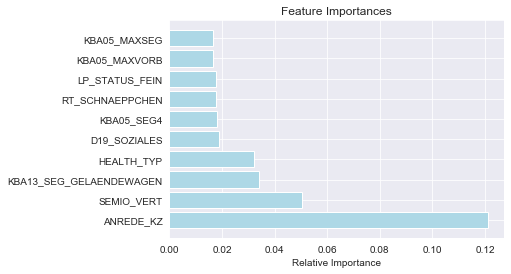

In [37]:
print(columns)
print(values)
sns.set_style('darkgrid')
plt.title('Feature Importances')
plt.barh(np.arange(num_feature), values, color='lightblue', align='center', label = "Feature Weight")

plt.yticks(np.arange(num_feature), columns)
plt.xlabel('Relative Importance')
plt.show()

### 过拟合和泛化能力

不论是classifier还是regressor模型，auc值都非常高，可能存在过拟合问题，将两种模型运用于测试数据集后来评估模型的泛化能力
通过调节如下参数来防止模型过拟合：n_estimators、max_depth，对于样本存在的不均衡情况设置subsample参数，在模型中添加alpha和lambda系数，代表L1和L2正则化，提高模型泛化能力

## Part 3:Kaggle比赛

你已经搭建了一个用于预测人们有多大程度上会回应邮购活动的模型，是时候到Kaggle上检验一下这个模型了。如果你点击这个 [链接](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140)，你会进入到比赛界面（如果你已经有一个Kaggle账户的话）如果你表现突出的话，你将有机会收到Arvato或Bertelsmann的人力资源管理的经理的面试邀约！

你比赛用提交的文件格式为CSV，该文件含2列。第一列是"LNR"，是"TEST"部分每个顾客的ID。第二列是"RESPONSE"表示此人有多大程度上会参加该活动，可以是某种度量，不一定是概率。你应该在第2部分已经发现了，该数据集存在一个巨大的输出类不平衡的问题，也就是说大部分人都不会参加该邮购活动。因此，预测目标人群的分类并使用准确率来衡量不是一个合适的性能评估方法。相反地，该项竞赛使用AUC衡量模型的性能。"RESPONSE"列的绝对值并不重要：仅仅表示高的取值可能吸引到更多的实际参与者，即ROC曲线的前端曲线比较平缓。

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [17]:
cleaned_mailout_test = RandomForest_Fill_Null(mailout_test,70,5,10)

Chunk 1 Finished
Chunk 2 Finished
Chunk 3 Finished
Chunk 4 Finished
Chunk 5 Finished
Chunk 6 Finished
Chunk 7 Finished
Chunk 8 Finished
Chunk 9 Finished
Replace X and XX with np.nan Finished
Drop columns with high null value ratio Finished
Assign Type to Float Finished
column CAMEO_DEU_2015 to dummy finished
column OST_WEST_KZ to dummy finished
To Dummy Finished
Split All Feature Columns into two lists finished
RF Fill Null Round 1 Finished
------------------------

RF Fill Null Round 2 Finished
------------------------

RF Fill Null Round 3 Finished
------------------------

RF Fill Null Round 4 Finished
------------------------

RF Fill Null Round 5 Finished
------------------------

RF Fill Null Round 6 Finished
------------------------

RF Fill Null Round 7 Finished
------------------------

RF Fill Null Round 8 Finished
------------------------

RF Fill Null Round 9 Finished
------------------------

RF Fill Null Round 10 Finished
------------------------

RF Fill Null Round 11 Fi

**使用VotingClassifier直接预测0或者1因样本不平衡出现严重偏差**

In [189]:
pred_clf = voting_clf.predict(cleaned_mailout_test)

In [190]:
clf_prediciton = pd.DataFrame(index=mailout_test['LNR'].astype('int'), data=pred_clf)
clf_prediciton.rename(columns = {0:"RESPONSE"},inplace = True)

In [191]:
clf_prediciton['RESPONSE'].value_counts()

0    42831
1        2
Name: RESPONSE, dtype: int64

**使用VotingRegressor预测值，拟合X_smo, Y_smo**

In [244]:
voting_reg.fit(X_smo, Y_smo)

VotingRegressor(estimators=[('forest_reg',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=10,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=200,
                               

In [245]:
pred_reg = voting_reg.predict(cleaned_mailout_test)
kreg_prediciton = pd.DataFrame(index=mailout_test['LNR'].astype('int'), data=pred_reg)
reg_prediciton.rename(columns = {0:"RESPONSE"},inplace = True)

In [ ]:
reg_prediciton.to_csv("Voting_Submission_First_Time.csv")

voting模型拟合过采样的样本，最终Kaggle比赛auc得分为0.692，这个分数不高，说明了模型在训练数据集上存在着严重的过拟合问题，考虑到是否是BorderlineSMOTE算法过采样反而降低了学习效果

**使用VotingRegressor拟合ADASYN过采样的数据集**

In [16]:
voting_reg.fit(X_ads, Y_ads)

VotingRegressor(estimators=[('forest_reg',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=16,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=140,
                               

In [18]:
pred_ads = voting_reg.predict(cleaned_mailout_test)
ads_prediciton = pd.DataFrame(index=mailout_test['LNR'].astype('int'), data=pred_ads)
ads_prediciton.rename(columns = {0:"RESPONSE"},inplace = True)

In [19]:
ads_prediciton.to_csv("Voting_Submission_Second_Time.csv")

使用VotingRegressor拟合X_ads和Y_ads，最终auc分数为0.693，两种过采样方法得到的结果都不算是特别优秀，存在比较严重的过拟合问题

**使用VotingRegressor拟合清洗后、未过采样的数据集Cleaned_X，Y**

In [255]:
voting_reg.fit(cleaned_X, Y)

VotingRegressor(estimators=[('forest_reg',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=15,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=150,
                               

In [258]:
pred_reg2 = voting_reg.predict(cleaned_mailout_test)
reg_prediciton2 = pd.DataFrame(index=mailout_test['LNR'].astype('int'), data=pred_reg2)
reg_prediciton2.rename(columns = {0:"RESPONSE"},inplace = True)

In [ ]:
reg_prediciton2.to_csv("prediction3_.csv")

使用VotingRegressor拟合Cleaned_X和Y，最终auc分数0.73556，过采样算法加深了模型的过拟合问题，在原始数据集上，模型体现了一定的泛化能力

**对于参数：可以通过使用GridSearchCV寻找最合适的参数，如下所示**

**但GridSearchCV需要耗费大量的时间来寻找最优的参数，之前的参数效果较好，故直接使用之前的参数**

In [ ]:
%%time
parameters = {
    'max_depth': [5,10],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [200],
    'subsample': [0.7, 0.9],
    'reg_alpha': [0,1]
}
raw_xgb = xgboost.XGBRegressor(objective='binary:logistic')
%%time
gridsearch = GridSearchCV(raw_xgb, param_grid=parameters, scoring='roc_auc', cv=3, verbose=True)
gridsearch.fit(X_train_new, y_train_new)
gridsearch.best_params_

## 结论

+ 首先使用了Xgboost和RandomForest对清洗后的数据集进行了拟合，发现算法的性能较差；
+ 使用交叉验证而不是直接将数据集分为training和testing，验证了算法的可行性，发现了样本存在较为严重的不均衡问题；
+ 使用了BorderlineSMOTE和ADASYN两种过采样算法来平衡样本；
+ 应问题本身为分类问题，所以尝试使用Classifier预测分类，发现算法在过采样后的训练数据集上过拟合，在测试集上表现严重低下；
+ 改为使用Regressor回归器，预测成为潜在顾客的分数值，并运用了Voting的策略思想，结合Xgboost和RandomForest两种算法来提高泛化性能；
+ 对Xgboost和RandomForest的树的数目、树的深度进行限制，xgboost中添加L1和L2正则化项，提高模型的泛化性能；
+ 将最终模型运用在三种测试集上，1. BorderlineSMOTE算法过采样的数据；2. ADASYN算法过采样的数据；3. 未经采样的数据集

**在整个模型使用和算法调参的过程中，不断迭代试错，找到合适的算法参数、结合bagging思想和boosting思想的两种模型，得到最终auc分数：0.73556**
